# Advanced Lane Finding - The Pipeline 
<img style="float: left;" src="https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg">
<br>

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. 

The Project
-------

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

# plt.rcParams["figure.figsize"] = (16, 12)
# %config InlineBackend.figure_format = "retina"

# Show all output values
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Auto reload outside files
%load_ext autoreload
%autoreload 2

## Pipeline

### 0. Read in an example image

In [2]:
from advanced_lane_finding import bgr2rgb

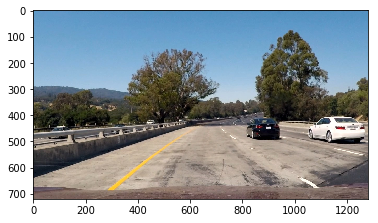

In [3]:
fname = 'test_images/test1.jpg'
init_img = cv2.imread(fname)
plt.imshow(bgr2rgb(init_img));
# cv2.imwrite('output_images/00_initial_image.png', init_img);

### 1. Calibrate the camera

In [4]:
from advanced_lane_finding import calibrate

In [5]:
nx = 9  # the number of inside corners in x
ny = 6  # the number of inside corners in y
# Read in all calibration chessboard images
cal_images = glob.glob('camera_cal/calibration*.jpg')
imgsize =(1280, 720)
# Calibrate the camera
mtx, dist = calibrate(nx, ny, cal_images, imgsize)

<img style="float: left;" src="output_images/01_calibration.png">
<br>

### 2. Undistort Image

In [6]:
from advanced_lane_finding import undistort

In [7]:
undist = undistort(init_img, mtx, dist)
# cv2.imwrite('output_images/02_undistorted.png', undist)

In [8]:
from advanced_lane_finding import plot_two

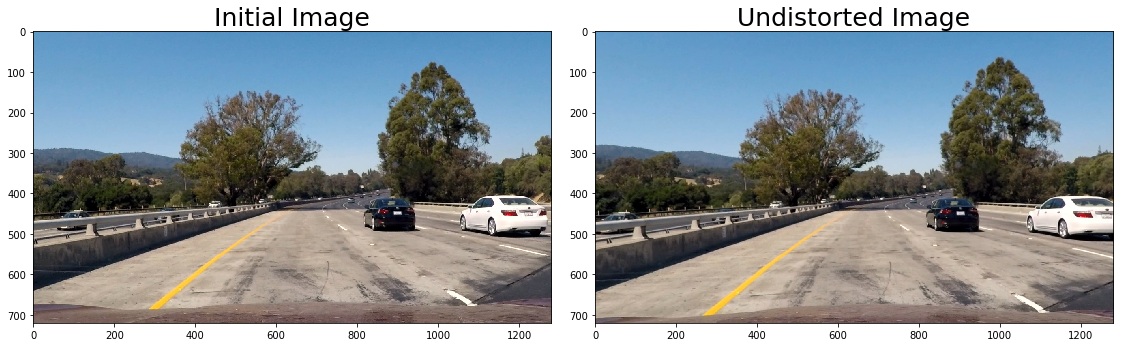

In [9]:
plot_two(init_img, 'Initial Image', 
             undist, 'Undistorted Image')

### 3. Apply color threshold

In [10]:
from advanced_lane_finding import color_threshold_s

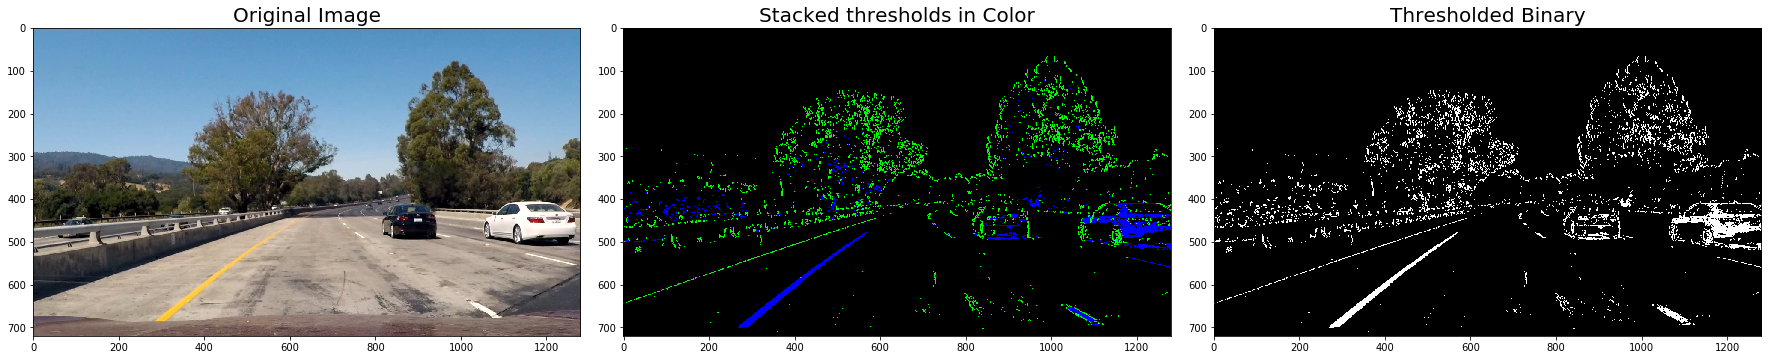

In [11]:
thresholded_colored, thresholded_binary = color_threshold_s(undist)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bgr2rgb(init_img));
ax1.set_title('Original Image', fontsize=20);

ax2.imshow(thresholded_colored);
ax2.set_title('Stacked thresholds in Color', fontsize=20);

ax3.imshow(thresholded_binary, cmap='gray');
ax3.set_title('Thresholded Binary', fontsize=20);

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);

# plt.savefig('output_images/03_color_thresholded.png');

### 4. Comupte the Matrix of Perspective Transform

In [12]:
from advanced_lane_finding import get_perspective_m

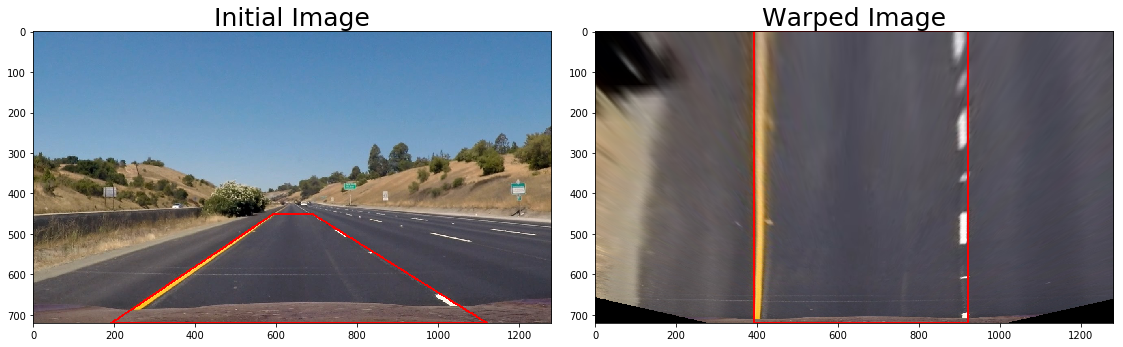

In [13]:
# Four source coordinates
src_pts = np.float32(
    [[688, 450],
     [1120, 720],
     [192, 720],
     [593, 450]])

# four desired coordinates
buffer = 200  # The ammount of more pixels to contain in the birdview image
# to make sure the lanes are always contained no matter how big
# the curvature is.
dst_pts = np.float32(
    [[1120 - buffer, 0],
     [1120 - buffer, 720],
     [192 + buffer, 720],
     [192 + buffer, 0]])


## Use straight line image for computing the matrix of Perspective transform
straightline_img = cv2.imread('test_images/straight_lines1.jpg')
M, Minv = get_perspective_m(straightline_img, imgsize, src_pts, dst_pts)
# Creat warped image
warped = cv2.warpPerspective(straightline_img, M, imgsize, flags=cv2.INTER_LINEAR)
warped = cv2.polylines(warped, [np.int32(dst_pts)], 1, [0,0,255], 4)
straightline_img = cv2.polylines(straightline_img, [np.int32(src_pts)], 1, [0,0,255], 4)
plot_two(straightline_img, 'Initial Image', warped, 'Warped Image')

### 5. Apply a perspective transform

In [14]:
from advanced_lane_finding import warp

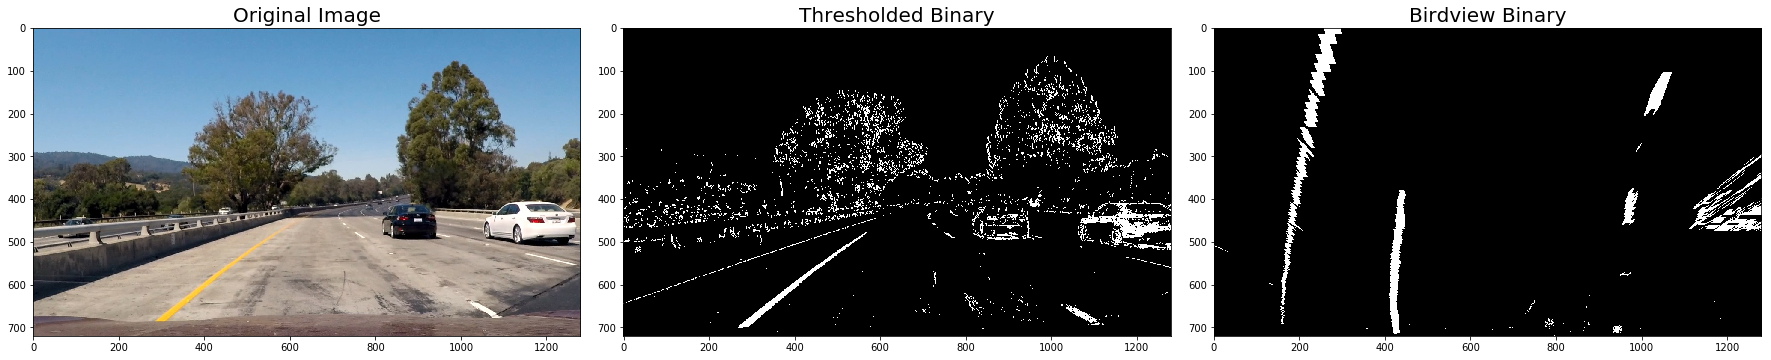

In [15]:
birdview_binary = warp(thresholded_binary, M, imgsize)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bgr2rgb(init_img));
ax1.set_title('Original Image', fontsize=20);

ax2.imshow(thresholded_binary, cmap='gray');
ax2.set_title('Thresholded Binary', fontsize=20);

ax3.imshow(birdview_binary, cmap='gray');
ax3.set_title('Birdview Binary', fontsize=20);

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.);

plt.savefig('output_images/05_birdview_binary.png');

### 6. Detect Lane Lines

In [16]:
# Set the width of the windows +/- margin
init_margin = 100
margin = 50
# Set minimum n3mber of pixels found to recenter window
minpix = 50

In [17]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension as US regulation
standard_lane_width_in_px = (1120-buffer) - (192+buffer)
xm_per_pix = 3.7 / standard_lane_width_in_px  # meters per pixel in x dimension as US regulation

In [18]:
from advanced_lane_finding import initial_find_lane, find_lane, process_out_img

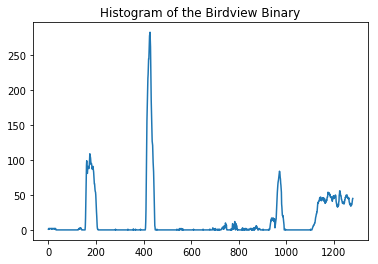

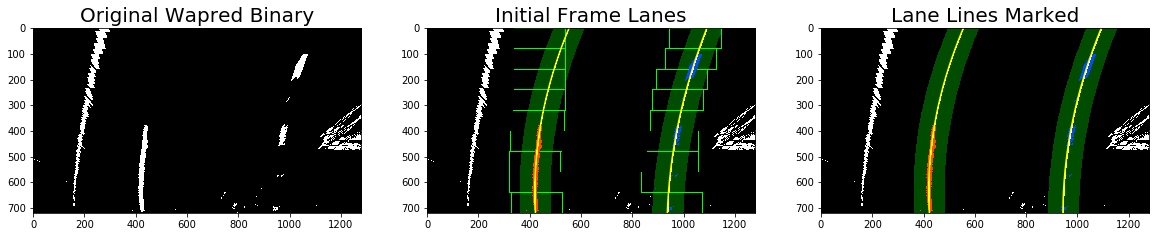

In [19]:
# Generate x and y values for plotting
ploty = np.linspace(0, 719, 720)
# print(ploty.shape)

# Plot the inital frame
init_out_img, left_fit, right_fit, leftx, lefty, rightx, righty, init_left_fitx, init_right_fitx, histogram = initial_find_lane(birdview_binary)
init_out_img= process_out_img(init_out_img, left_fit, right_fit, init_left_fitx, init_right_fitx,leftx, lefty, rightx, righty)

# Plot the second frame and after
# To-Do: How to detect that a finding of lane line failed??
out_img, left_fit, right_fit, leftx, lefty, rightx, righty, left_fitx, right_fitx = find_lane(birdview_binary, left_fit, right_fit)
out_img = process_out_img(out_img, left_fit, right_fit, left_fitx, right_fitx, leftx, lefty, rightx, righty)

# Do the plotting
plt.plot(histogram)
plt.title('Histogram of the Birdview Binary')
f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
ax1.imshow(birdview_binary, cmap='gray')
ax1.set_title('Original Wapred Binary', fontsize=20)
ax2.imshow(init_out_img)
ax2.plot(init_left_fitx, ploty, color='yellow')
ax2.plot(init_right_fitx, ploty, color='yellow')
ax2.set_title('Initial Frame Lanes', fontsize=20)
ax3.imshow(out_img)
ax3.plot(left_fitx, ploty, color='yellow')
ax3.plot(right_fitx, ploty, color='yellow')
ax3.set_title('Lane Lines Marked', fontsize=20);
#plt.savefig('06_lane_lines_detected.png');

### 7. Sanity Check

In [20]:
from advanced_lane_finding import evaluate, sanity_check

In [21]:
y_eval = np.max(ploty)
curvature_init, offset_init, lane_width_init, lane_dist_delta_init = evaluate(y_eval, 
                                                                              ploty, 
                                                                              init_left_fitx, 
                                                                              init_right_fitx)
valid = sanity_check(curvature_init, offset_init, lane_width_init, lane_dist_delta_init)
print('The Curvature of left and right lanes on initial frame:\n', curvature_init)
print('The offset:\n', offset_init)
print('The Lane Width:\n', lane_width_init)
print('Delta of MinMax Lanes distance:\n', lane_dist_delta_init)
print('Valid:', valid)

curvature, offset, lane_width, lane_dist_delta = evaluate(y_eval, ploty, left_fitx, right_fitx)
valid = sanity_check(curvature, offset, lane_width, lane_dist_delta)
print('\nThe Curvature of left and right lanes on normal frame:\n', curvature)
print('The offset:\n', offset)
print('The Lane Width:\n', lane_width)
print('Delta of MinMax Lanes distance:\n',lane_dist_delta)
print('Valid:', valid)

The Curvature of left and right lanes on initial frame:
 (380.87241140990841, 502.24787922844274)
The offset:
 -0.0398646527598
The Lane Width:
 3.60492945772
Delta of MinMax Lanes distance:
 0.174973704425
Valid: True

The Curvature of left and right lanes on normal frame:
 (372.62952214713903, 437.89484907050371)
The offset:
 -0.0378303375219
The Lane Width:
 3.64966954083
Delta of MinMax Lanes distance:
 0.123975111044
Valid: True


### 8. Warp the lane boundaries back

In [22]:
from advanced_lane_finding import warpback

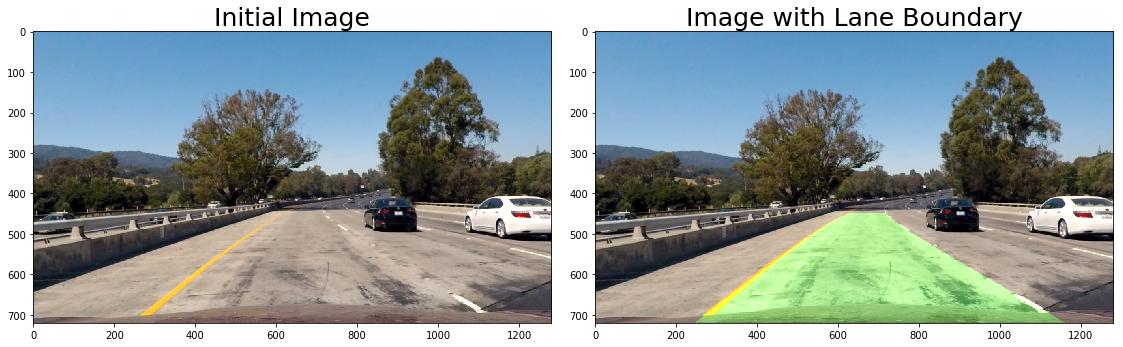

In [23]:
img_with_lane_boundary = warpback(birdview_binary, undist, 
                                  left_fitx, right_fitx, ploty, Minv, imgsize)

plot_two(undist, 'Initial Image', img_with_lane_boundary, 'Image with Lane Boundary')

### 9. Add text of information to final image

In [24]:
from advanced_lane_finding import add_text2, plot_one

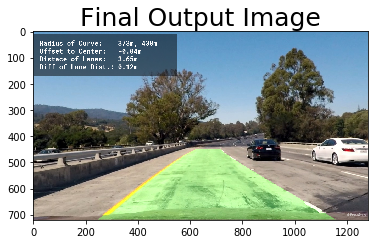

In [25]:
text = '''
Radius of Curve:    {:.0f}m, {:.0f}m
Offset to Center:   {:.2f}m
Distace of Lanes:   {:.2f}m
Diff of Lane Dist.: {:.2f}m
'''.format(curvature[0], curvature[1], offset, lane_width, lane_dist_delta)
img = add_text2(img_with_lane_boundary, text)
plot_one(img, 'Final Output Image');
# cv2.imwrite('output_images/10_final_output.png', img)

<img style="float: left;" src="output_images/10_final_output.png">
<br>

------
# Complete pipeline

In [26]:
from advanced_lane_finding import Line, pipeline

In [28]:

nx = 9  # the number of inside corners in x
ny = 6  # the number of inside corners in y
# Read in all calibration chessboard images
cal_images = glob.glob('camera_cal/calibration*.jpg')
imgsize = (1280, 720)
# Generate x and y values for plotting
ploty = np.linspace(0, imgsize[1] - 1, imgsize[1])

# Calibrate the camera
mtx, dist = calibrate(nx, ny, cal_images, imgsize)

# Four source coordinates
src_pts = np.float32(
    [[688, 450],
     [1120, 720],
     [192, 720],
     [593, 450]])

# four desired coordinates
buffer = 200  # The ammount of more pixels to contain in the birdview image
# to make sure the lanes are always contained no matter how big
# the curvature is.
dst_pts = np.float32(
    [[1120 - buffer, 0],
     [1120 - buffer, 720],
     [192 + buffer, 720],
     [192 + buffer, 0]])

# Use straight line image for computing the matrix of Perspective transform
straightline_img = cv2.imread('test_images/straight_lines1.jpg')
M, Minv = get_perspective_m(straightline_img, imgsize, src_pts, dst_pts)

# Set the width of the windows +/- margin
init_margin = 100
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30 / 720  # meters per pixel in y dimension as US regulation
standard_lane_width_in_px = (1120 - buffer) - (192 + buffer)
xm_per_pix = 3.7 / standard_lane_width_in_px  # meters per pixel in x dimension as US regulation

# Set n of iterations of data to store in the line calss
n = 5

Initialize the lane finding....


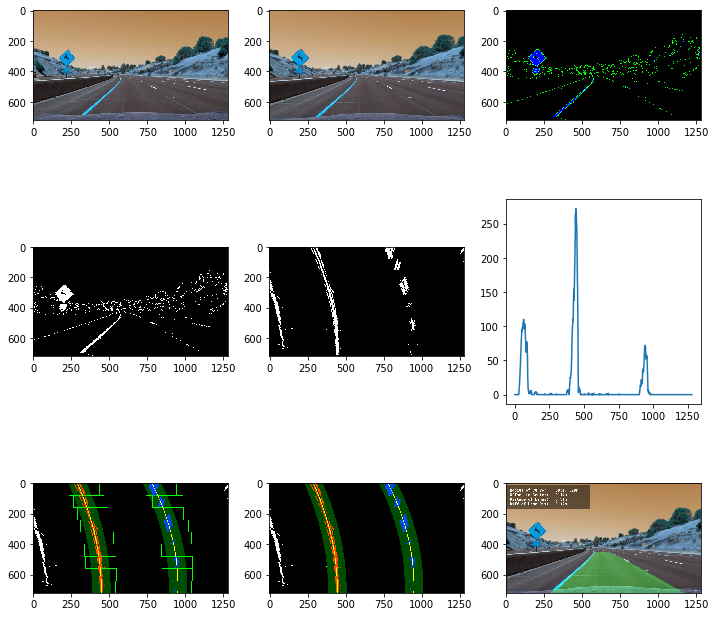

In [29]:
# Create an instance of Line Class to sotre all the characteristics of each line detection
l_line = Line()  # left line
r_line = Line()  # right line

fname = 'test_images/test2.jpg'
init_img = mpimg.imread(fname)
# plt.imshow(bgr2rgb(init_img));
pipeline(init_img, debug=False, only_final=True);

# Process the video clip

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
input_video_name = 'project_video.mp4'
output_video_name = 'output_project_video_final.mp4'

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip1 = VideoFileClip(input_video_name)
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video_name, audio=False)

In [36]:
# Present the Video
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output_video_name))